[adapted from tflite-speech-recognition](https://github.com/ShawnHymel/tflite-speech-recognition/blob/master/01-speech-commands-mfcc-extraction.ipynb)

In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [84]:
dataset_path = "labeled"
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

shipping
not_shipping


In [85]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['shipping', 'not_shipping']


In [86]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

106
321
Total samples: 427


In [87]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [88]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)
    
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

labeled/not_shipping
labeled/shipping


In [89]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)


In [90]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

[len(w) for w in (filenames_val, filenames_test, filenames_train)]

[42, 42, 343]

In [91]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [92]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [93]:
%%time

# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    #if index >= 500:
    #    break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

CPU times: user 27.5 s, sys: 4.1 s, total: 31.6 s
Wall time: 5.36 s


In [94]:
print('% of problematic samples:', prob_cnt)

% of problematic samples: 0


labeled/not_shipping/20191019Z1754_m015.wav
(16, 16)


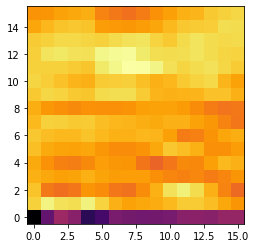

In [95]:
idx = 8

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])
print(path)
# Create MFCCs
mfccs = calc_mfcc(path)
print(mfccs.shape)
#print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

In [96]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [97]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Removed percentage: 0.0
Removed percentage: 0.0
Removed percentage: 0.0


In [98]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [99]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files


['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']